# Методы нетренерованной сегментации изображений.

В данной ноутбуке разобраны несколько методов сегментации изображений, что значит разделение изображения на составные части, соответствующие различным предметам. 

1. Один из самых первых методов, метод роста областей. Требует от пользователя ввода разметки изображения, хотя бы по одному пикселю от каждого сегментируемого объекта. Далее построение областей происходит итеративно, для каждого пикселя, соседнего с уже размеченной областью, смотрится его расстоянии по яркости до средней яркости у области. Пиксель с минимальным расстоянием, не превышающим пороговое значение, добавляется к соответствующей области. В моем примере реазизации для генерации семян роста используется функция, схема работы которой примерно следующая - сначала изображение усредняется для удаления шумов, далее смотрятся значения яркости, превышающие пороговые, затем в каждой связной области смотрится точка, наиболее удаленная от краев области. Далее снова выбирается некоторая доля точек, которые принимаются за семена роста. Далее, оригинальный алгоритм должен каждый раз присоединять неклассифицированную точку с минимальным расстоянием яркости до группы. В моей версии реализован подход, когда все области растут одновременно. 

2. Сегментация методом водораздела. Для нее рассматривается опять же яркость изображения. Утверждается, что те места, где яркость меняется быстрее всего --- границы изображений. Более того, если рассматривать яркость как поверхность, где чем ярче точка, тем "выше" она находится, то границы изображений -- соответсвенно водоразделы, сегментирующие изображение. 

In [8]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [9]:
img = cv2.imread('./samples/coins.jpg')
img = img[..., ::-1]

In [10]:
def compare(image, methode):
    img = image.copy()
    fig, axs = plt.subplots(1, 2, figsize=(20,10))
    axs[0].imshow(image)
    axs[1].imshow(methode(image))

In [11]:
def process_image_watercut(img):
    image = img.copy()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
    sure_bg = cv2.dilate(opening,kernel,iterations=3)

    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)
    ret, markers = cv2.connectedComponents(sure_fg)
    markers = markers+1
    markers[unknown==255] = 0
    markers = cv2.watershed(img,markers)
    img[markers == -1] = [255,0,0]
   
    return img

In [12]:
def neighbors(mat, row, col, radius=1):
    neighbors = []
    for i in range(row - radius, row + radius + 1):
        for j in range(col - radius, col + radius + 1):
            neighbors.append((i, j))
    neighbors.remove((row, col))
    n_1 =  [item for item in neighbors if item[0]>=0 and item[0] < mat.shape[0] and item[1]>=0 and item[1] < mat.shape[1]]
    return n_1

def seed_finder(gray):
    kernel = np.ones((3,3),np.uint8)
    kernel = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]], dtype=np.float32)

    opening = cv2.morphologyEx(gray,cv2.MORPH_OPEN,kernel, iterations = 2)
    _, opening = cv2.threshold(opening,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    distances =  cv2.normalize(dist_transform, dist_transform, 0, 1.0, cv2.NORM_MINMAX)
    _, distances = cv2.threshold(distances, 0.90, 1.0, cv2.THRESH_BINARY)
    distances = np.uint8(distances)
    _, components = cv2.connectedComponents(distances)
    return components
    

def seed_segmentation_simultanious(image):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    components = seed_finder(gray)
    
    unique = np.unique(components)
    seeds = []
    for i in unique[1:]:
        seeds.append([np.where(components == i)[0][0], np.where(components == i)[1][0]])
        
    markers = components.copy()
    markers[markers == 0] = -1
    treshhold = 255 * .2
    changed = 0
    areas = list(range(1, np.max(markers)+10))
    markers_cash = markers.copy()
    for i in range(30):
        markers = markers_cash.copy()
        for i in range(len(areas)):
            areas[i] = np.mean(gray[markers == i])
        for row in range(markers.shape[0]):
            for column in range(markers.shape[1]):
                if markers[row, column] != -1:
                    neis = neighbors(markers, row, column)
                    for n in neis:
                        if markers[n] == -1:
                            if np.abs(gray[n] - areas[markers[row, column]]) < treshhold:
                                markers_cash[n] = markers[row, column]
                                changed += 1
                            
    
    markers[markers == -1] = 0
    return markers


C:\Users\sevag\Anaconda3\envs\mechamt\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\sevag\Anaconda3\envs\mechamt\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


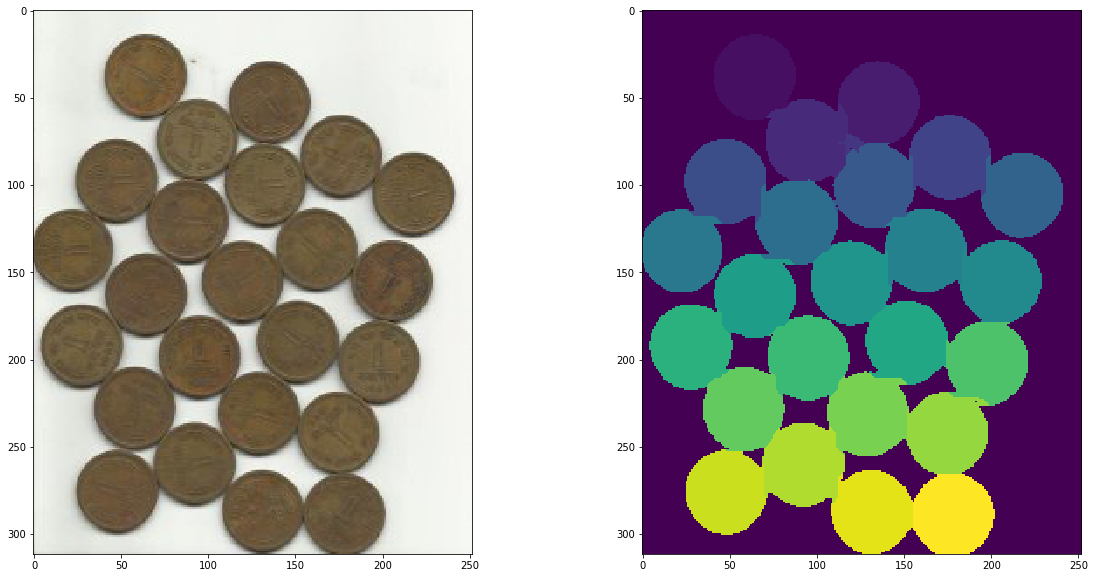

In [13]:
compare(img, seed_segmentation_simultanious)

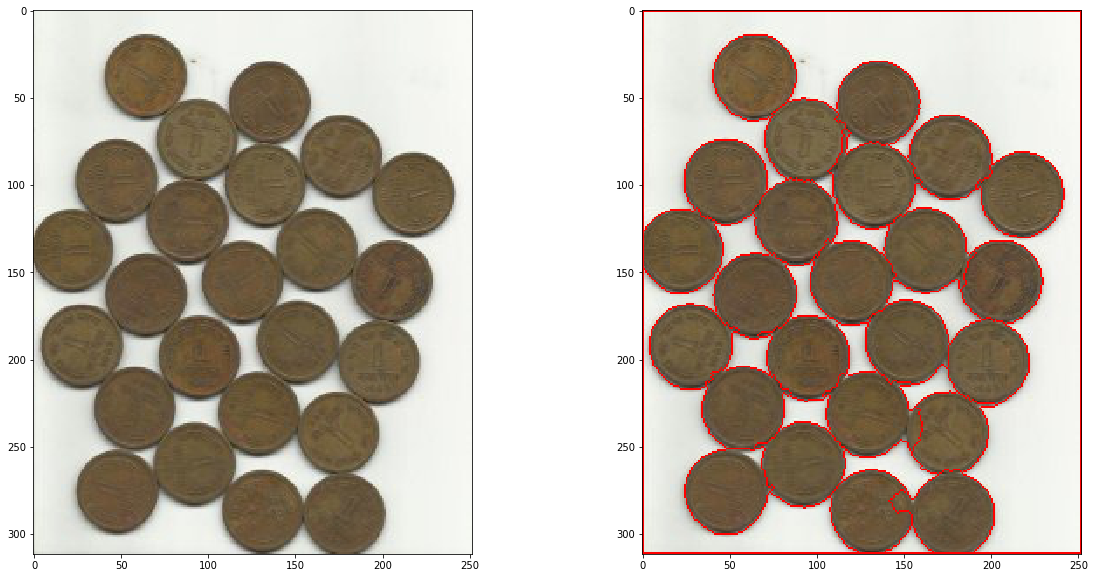

In [14]:
compare(img, process_image_watercut)